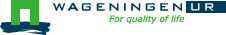



# Building your own model with PCSE

This Jupyter notebook will help you understand the building blocks of PCSE and how to create your own models with it.

Allard de Wit, August 2024

**Prerequisites for running this notebook**

Several packages need to be installed for running PCSE/WOFOST:

  1. PCSE and its dependencies. See the [PCSE user guide](http://pcse.readthedocs.io/en/stable/installing.html) for more information;
  2. The `pandas` module for processing and storing WOFOST output;
  3. The `matplotlib` module for generating charts

**Important notice**

If you start experimenting with this notebook and change the examples you may need to frequently restart the jupyter kernel. Python loads modules only once and therefore changes that you make to the code may not be reflected in the PCSE model results until you restart the kernel which forces python to reload all modules.

# 使用PCSE构建自己的模型

这本Jupyter笔记本将帮助你了解PCSE的构建模块以及如何使用它创建自己的模型。

阿拉德·德·维特，2024年8月

**运行此笔记本的先决条件**

要运行PCSE/WOFOST，需要安装以下几个软件包：

1. PCSE及其依赖项。欲了解更多信息，请参阅[PCSE用户指南](http://pcse.readthedocs.io/en/stable/installing.html)；
2. 用于处理和存储WOFOST输出的“pandas”模块；
3. 用于生成图表的“matplotlib”模块。

**重要提示**

如果你开始使用这本笔记本进行试验并更改示例，可能需要频繁重启Jupyter内核。Python只会加载一次模块，因此，在你重启内核迫使Python重新加载所有模块之前，你对代码所做的更改可能不会反映在PCSE模型的结果中。

# 1. Importing the relevant modules


### 代码解释

1.  **%matplotlib inline**：
    
    -   这是一个 Jupyter Notebook 中的魔术命令，用于在 Notebook 中直接显示图形，而不是在单独的窗口中显示。
2.  **导入模块**：
    
    -   `sys`：用于访问系统相关的功能，如获取 Python 版本信息。
    -   `Path`：用于处理文件路径，方便文件操作。
    -   `datetime`：用于处理日期和时间，这里使用 `dt` 作为别名。
    -   `yaml`：用于解析 YAML 格式的配置文件，常用于存储配置信息。
    -   `pandas`：用于数据处理和分析，提供 DataFrame 和 Series 等数据结构。
    -   `matplotlib`：用于绘图，提供丰富的绘图功能。
    -   `matplotlib.pyplot`：用于绘制图形，提供简单的绘图接口。
    -   `pcse`：用于构建和运行作物模拟模型，提供作物生长模拟的环境和工具。
3.  **设置绘图样式**：
    
    -   `matplotlib.style.use("ggplot")`：使用 ggplot 风格的绘图样式，使图形更具视觉吸引力。
4.  **打印版本信息**：
    
    -   `print("This notebook was built with:")`：打印提示信息。
    -   `print(f"python version: {sys.version}")`：打印当前使用的 Python 版本。
    -   `print(f"PCSE version: {pcse.__version__}")`：打印当前使用的 PCSE 版本。

通过这些代码，你可以确保 Notebook 环境中已经正确导入了所需的模块，并且可以查看当前使用的 Python 和 PCSE 版本信息。这对于调试和版本管理非常重要。

In [1]:
# %matplotlib inline 是 Jupyter Notebook 中的一个命令，用于在 Notebook 中直接显示图形
%matplotlib inline

# 导入 sys 模块，用于访问系统相关的功能
import sys

# 导入 pathlib 模块中的 Path 类，用于处理文件路径
from pathlib import Path

# 导入 datetime 模块中的 dt 别名，用于处理日期和时间
import datetime as dt

# 导入 yaml 模块，用于解析 YAML 格式的配置文件
import yaml

# 导入 pandas 模块，用于数据处理和分析
import pandas as pd

# 导入 matplotlib 模块，用于绘图
import matplotlib
# 使用 ggplot 风格的绘图样式
matplotlib.style.use("ggplot")

# 导入 matplotlib.pyplot 模块，用于绘制图形
import matplotlib.pyplot as plt

# 导入 pcse 模块，用于构建和运行作物模拟模型
import pcse

# 打印当前 Notebook 使用的 Python 和 PCSE 版本信息
print("This notebook was built with:")
print(f"python version: {sys.version}")
print(f"PCSE version: {pcse.__version__}")

This notebook was built with:
python version: 3.12.6 (tags/v3.12.6:a4a2d2b, Sep  6 2024, 20:11:23) [MSC v.1940 64 bit (AMD64)]
PCSE version: 6.0.8


# 2. 开发一个基础模型

农学中最基础的模型之一是积温模型（Growing Degree Day model）。该模型通过计算高于基础温度的度数来模拟植物的物候发育。通常这种计算是基于日平均温度进行的，不过有些模型会使用逐时温度。

## 模型逻辑

在下面的单元格中，我们将实现一个积温模型。这个模型有一个状态变量（积温：`GDD`）、一个速率变量（积温的日增长量 `rGDD`）以及一个参数（`BaseTemperature`）。更多解释可查看下面代码中的注释。

我们使用单元格顶部的 `%%writefile` 指令将这个模型写入到一个名为 `gddmodel.py` 的文件中。

In [2]:
%%writefile gddmodel.py 
# 使用%%writefile命令将代码写入文件gddmodel.py


# 这里我们导入PCSE中的一些组件，它们是构建任何模型的基本组成部分。
from pcse.base import SimulationObject, StatesTemplate, RatesTemplate, ParamTemplate
from pcse.traitlets import Float

# 在PCSE中的模型总是继承自SimulationObject
class GrowingDegreeDayModel(SimulationObject):
    """一个简单的模型，用于在作物生长周期的开始和结束之间积累生长度日。"""

    # 这定义了模型参数。它继承自ParamTemplate，这确保参数接收其值，并在参数缺失时发出信号。
    class Parameters(ParamTemplate):
        # 定义基温参数
        BaseTemperature = Float

    # 状态变量总是继承自StatesTemplate。StatesTemplate提供了某些行为，
    # 如状态变量必须被初始化。
    class StateVariables(StatesTemplate):
        # 定义生长度日状态变量
        GDD = Float

    # 速率变量类似于状态变量，但会自动初始化为零。
    class RateVariables(RatesTemplate):
        # 定义生长度日的变化率
        rGDD = Float

    def initialize(self, day, kiosk, parameters):
        """初始化仅在模型启动时运行一次。
        
        它始终有三个变量：
        - day: 模型开始的日期
        - kiosk: 变量Kiosk，这是一个在模型组件间共享的对象
        - parameters: 提供模型参数的对象
        """
        # 下面的代码初始化参数、状态和速率变量。
        # 注意状态变量（这里：GDD）必须提供初始值。
        self.params = self.Parameters(parameters)
        self.states = self.StateVariables(kiosk, GDD=0.0)
        self.rates = self.RateVariables(kiosk)

    def calc_rates(self, day, drv):
        """计算在当前日期发生的改变率。
        
        它始终有两个变量：
        - 当前日期（一个日期）
        - 驱动变量`drv`，包含气象输入
        """
        # 这里我们计算GDD的增加，并将其赋值给速率变量rGDD
        self.rates.rGDD = max(0.0, drv.TEMP - self.params.BaseTemperature)

    def integrate(self, day, delt):
        """这执行速率变化对状态的积分。
        
        它始终有两个变量：
        - 当前日期
        - 时间步长，固定为1.0天
        """
        # 这里我们将rGDD乘以delt加到GDD上。
        # 与`delt`相乘主要是为了教育目的（因为delt=1.0），尽管这在未来可能会改变。
        self.states.GDD += self.rates.rGDD * delt

Overwriting gddmodel.py


In [3]:
# # 导入PCSE库中用于构建任何模型的基本组件
# from pcse.base import SimulationObject, StatesTemplate, RatesTemplate, ParamTemplate
# from pcse.traitlets import Float

# # 定义一个继承自SimulationObject的模型类，所有PCSE中的模型都需继承自SimulationObject
# class GrowingDegreeDayModel(SimulationObject):
#     """
#     一个简单的模型，用于计算作物生长周期内从开始到结束的生长度日。
#     """

#     # 定义模型参数，继承自ParamTemplate确保参数能够接收值，并在缺少参数时发出警告
#     class Parameters(ParamTemplate):
#         BaseTemperature = Float

#     # 定义状态变量，继承自StatesTemplate。StatesTemplate确保状态变量必须被初始化
#     class StateVariables(StatesTemplate):
#         GDD = Float   # 这里GDD存储累积的生长度日

#     # 定义速率变量，自动初始化为零
#     class RateVariables(RatesTemplate):
#         rGDD = Float  # 这里rGDD表示当前天生长度日的增加量

#     def initialize(self, day, kiosk, parameters):
#         """
#         初始化方法，仅在模型启动时运行一次。

#         参数：
#         - day: 模型开始的日期
#         - kiosk: VariableKiosk对象，模型组件间共享的数据容器
#         - parameters: 提供模型参数的对象
#         """
#         # 初始化参数、状态和速率变量。
#         # 注意状态变量（如这里GDD）必须提供初始值
#         self.params = self.Parameters(parameters)
#         self.states = self.StateVariables(kiosk, GDD=0.0)
#         self.rates = self.RateVariables(kiosk)

#     def calc_rates(self, day, drv):
#         """
#         calc_rates计算当前天的变化率。

#         参数：
#         - day: 当前日期
#         - drv: 驱动变量，包含气象输入数据
#         """
#         # 计算GDD的增加量，并赋值给速率变量rGDD
#         # 只有当当前温度减去基础温度大于等于0时，才增加GDD
#         self.rates.rGDD = max(0.0, drv.TEMP - self.params.BaseTemperature)

#     def integrate(self, day, delt):
#         """
#         根据变化率更新状态变量的值。

#         参数：
#         - day: 当前日期
#         - delt: 时间步长，此处固定为1.0天
#         """
#         # 将速率rGDD与时间步长delt相乘后累加到状态GDD上
#         # 乘以delt主要是为了教育目的，尽管delt通常为1.0，但未来可能有所改变
#         self.states.GDD += self.rates.rGDD * delt

请注意，上述模型实现中并不包含一个能逐步遍历模拟天数的时间循环。你无需自行实现这个时间循环，因为PCSE引擎会负责实现它，并将其与农业管理方面的信息进行同步。

## 一个模型配置文件

然而，PCSE引擎需要了解你的模型。此外，它还需要一些详细信息，比如在模拟过程中它需要收集的变量等情况。为此，我们要创建一个引擎配置文件。这个配置文件是用纯Python编写的，尽管它通常带有“.conf”扩展名，以表明它是一个配置文件而非模拟模型。

以下是上面所实现的积温模型的配置文件内容。我们将其写入到“gddmodel.conf”文件中。

In [4]:
from gddmodel import GrowingDegreeDayModel
from pcse.agromanager import AgroManager

# 土壤模块，目前不使用
SOIL = None

# 作物模拟的核心模块，这里指定为GrowingDegreeDayModel
CROP = GrowingDegreeDayModel

# 农事管理模块，这里使用AgroManager
AGROMANAGEMENT = AgroManager

# 输出变量，要保存的变量列表
# 如果不希望任何输出，可以设置为空列表
OUTPUT_VARS = ["GDD", "rGDD"]  # GDD为累积的生长度日，rGDD为每日新增的生长度日

# 输出间隔，可以选择“daily”（每日）、“dekadal”（十日）、“monthly”（每月）、“weekly”（每周）
# 对于“daily”输出，可以使用OUTPUT_INTERVAL_DAYS来调整连续输出之间的天数
OUTPUT_INTERVAL = "daily"
OUTPUT_INTERVAL_DAYS = 1  # 日输出间隔

# 一周中的哪一天作为输出日，星期一为0，星期日为6
OUTPUT_WEEKDAY = 0  # 设置为星期一

# 在CROP_FINISH信号时保存的摘要变量列表
# 若不需要任何摘要输出，可以设置为空列表
SUMMARY_OUTPUT_VARS = ["GDD"]  # GDD为最终累积的生长度日

# 在TERMINATE信号时保存的终端输出变量列表
# 若不需要任何终端输出，可以设置为空列表
TERMINAL_OUTPUT_VARS = []

## 定义模型输入
为了实际运行该模型，我们还需要PCSE中的一些其他组件。首先，需要“引擎（Engine）”；其次，我们需要“参数提供者（ParameterProvider）”，它是封装模型参数的组件；最后，我们需要一个用于读取天气数据的组件：“Excel天气数据提供者（ExcelWeatherDataProvider）”。

In [5]:
# Engine 是 pcse 的核心类之一，它负责管理和运行作物模型。你可以使用 Engine 类实例化一个引擎，然后向其中添加作物、土壤、管理等多个模块，最后调用其方法来执行完整的作物生命周期模拟。
from pcse.engine import Engine
# ParameterProvider 是一个抽象基类，用于提供模拟过程中所需的各类参数。在实际应用中，你需要创建这个类的子类来实现具体的参数读取逻辑。例如，参数可以从数据库、Excel 文件、CSV 文件或者硬编码的值中读取，具体取决于你的数据来源。
from pcse.base import ParameterProvider
# ExcelWeatherDataProvider 是 ParameterProvider 的一个具体实现，用于从 Excel 文件中读取气象数据。这通常包括温度、降水、太阳辐射等对作物生长至关重要的环境条件。使用这个类，你可以在模拟过程中输入真实的气象数据，以获得更接近现实的作物生长预测。
from pcse.input import ExcelWeatherDataProvider

最后，我们需要为运行模拟定义更多的输入内容。

首先是模型所需的参数。在本例中，唯一需要的参数是“基础温度（BaseTemperature）”，它通过一个Python字典来指定。在当前的模拟中，“基础温度”被设置为3.0摄氏度。接下来，参数字典通过“参数提供者（ParameterProvider）”进行封装。在当前模拟中，这样做并没有什么优势，但当需要大量参数时，其优势就很明显了。

接下来，需要定义农业管理方面的内容。模拟从2006年1月1日开始，而作物出苗时间是2006年3月15日。我们假设作物在2006年9月25日收获。在这个例子中，“作物名称（crop_name）”和“品种名称（variety_name）”只是标签，没有实际影响。

最后，使用“Excel天气数据提供者（ExcelWeatherDataProvider）”导入天气数据。

现在我们已经具备了运行模型所需的一切条件。

In [6]:
# 定义作物基础参数字典，这里以BaseTemperature为例，表示作物的基础温度
cropd = dict(BaseTemperature=3.0)

# 实例化ParameterProvider类，传入作物参数（cropdata）、站点参数（sitedata）和土壤参数（soildata）
params = ParameterProvider(cropdata=cropd, sitedata={}, soildata={})

# 使用yaml.safe_load()解析农业管理事件的YAML格式字符串
# 该字符串描述了作物日历事件、定时事件及状态事件
agro = yaml.safe_load("""
- 2006-01-01:
    CropCalendar:
        crop_name: 'GDDCrop'
        variety_name: 'GDDVariety'
        crop_start_date: 2006-03-15
        crop_start_type: emergence
        crop_end_date: 2006-09-25
        crop_end_type: harvest
        max_duration: 300
    TimedEvents: null
    StateEvents: null
""")

# 获取当前工作目录下的'data'/'meteo'/'nl1.xlsx'路径
weatherfile = Path.cwd() / "data" / "meteo" / "nl1.xlsx"

# 实例化ExcelWeatherDataProvider，传入天气数据文件路径
wdp = ExcelWeatherDataProvider(weatherfile)

## 运行实际模型
下面的代码通过启动引擎并向其提供参数、天气数据、农业管理信息以及配置文件的路径来运行积温模型。

In [7]:
# 构建配置文件路径，指向当前工作目录下的"gddmodel.conf"配置文件
gdd_config = Path.cwd() / "gddmodel.conf"

# 实例化Engine类，传入参数提供者（params）、天气数据提供者（wdp）、农业管理事件（agro）和配置文件（config）
gddmodel = Engine(params, wdp, agro, config=gdd_config)

# 调用run_till_terminate方法运行模型直到终止条件满足，即执行完整的作物生长周期模拟
gddmodel.run_till_terminate()

我们现在可以获取模型的输出结果，将其转换为一个Pandas数据框，并展示其内容。如你所见，该数据框包含“GDD”（积温）和“rGDD”（积温日增长量）这两列，它们是配置文件中“OUTPUT”（输出）部分所指定的变量。

In [8]:
# 从gddmodel对象获取输出结果
output_data = gddmodel.get_output()

# 使用pandas库将输出结果转换为DataFrame，并设置索引为"day"
# 这使得按日期进行数据排序和访问变得容易
df1 = pd.DataFrame(output_data).set_index("day")

# 显示DataFrame的最后几行，以预览数据的结尾部分
df1.tail()

,GDD,rGDD
day,,
2006-09-21,2253.60,18.65
2006-09-22,2272.25,16.25
2006-09-23,2288.50,17.25
2006-09-24,2305.75,15.60
2006-09-25,2321.35,13.20


Summary output is also available:

In [9]:
# 调用get_summary_output方法，该方法通常返回一个摘要信息，概括了模型的主要输出和关键指标
# 输出这些信息到控制台，便于快速查看模型运行的结果概览
print(gddmodel.get_summary_output())

[{'GDD': 2321.3500000000004}]


最后，我们可以绘制出GDD（积温）变量的结果，如下所示。

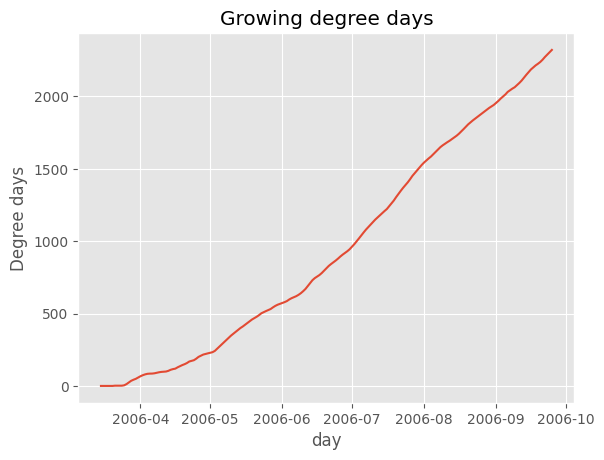

In [10]:
# 使用pandas DataFrame的.plot()方法绘制图表
# 参数:
#   title: 设置图表标题为 "Growing degree days"，用于描述图表主题
#   ylabel: 设置y轴标签为 "Degree days"，用于说明y轴数据含义

ax = df1.GDD.plot(title="Growing degree days", ylabel="Degree days")

如你所见，收获时的总积温天数为2321天。在最初的1.5个月里，由于气温较低，积温（GDD）值的累积相对缓慢，但随后在春末和夏季，累积速度加快，直至2006年9月25日达到收获日期。

# 3. 根据给定积温确定成熟时间

上述模型对于计算给定出苗日期和收获日期之间的积温值很有用。然而，在很多情况下，我们希望以预测性的方式应用该模型。例如，我们知道某一特定作物品种达到成熟所需的积温天数，并且我们想在给定的环境下预测该品种的成熟日期。要实现这一点，我们需要给我们的模型添加一些更多的细节。

首先，我们需要添加一个新的作物参数，用于定义达到成熟所需的积温天数，我们将其称为“成熟积温（GDDatMaturity）”。接下来，方便起见，我们要保存达到成熟的日期，所以引入了一个额外的状态变量“成熟日期（DayOfMaturity）”。最后，我们可以指示模拟引擎，由于已达到成熟状态，模拟可以停止。这是通过“_send_signal()”函数发送一个“作物完成（CROP_FINISH）”信号来实现的。后者是在模拟对象定义中定义的，由于我们的模型继承自模拟对象，所以我们可以直接使用它。

In [11]:
%%writefile gddmodel_v2.py
# 使用魔法命令将代码写入文件，便于后续在其他Python环境中导入此模块

# 导入必要的模块
import datetime as dt  # 使用datetime模块进行日期和时间的操作
from pcse.base import SimulationObject, StatesTemplate, RatesTemplate, ParamTemplate  # 引入pcse库中用于构建模型的基本类
from pcse.traitlets import Float, Instance  # 引入Float和Instance类，用于定义参数和状态变量的类型
from pcse import signals  # 引入signals模块，用于发送信号

# 定义GrowingDegreeDayModelV2类，继承自SimulationObject
class GrowingDegreeDayModelV2(SimulationObject):
    """
    A simple model to accumulate growing degree days up till GDDatMaturity.
    The model stores the maturity date and triggers a crop_finish signal when maturity is reached.
    简单的模型，累积生长度日直到成熟所需的总度日数，储存成熟日期并在达到成熟时触发作物完成信号。
    """

    # 定义参数类
    class Parameters(ParamTemplate):
        BaseTemperature = Float  # 定义基温参数，类型为浮点数
        GDDatMaturity = Float  # 定义成熟所需总度日的参数，类型为浮点数

    # 定义状态变量类
    class StateVariables(StatesTemplate):
        GDD = Float  # 当前累积的生长度日，类型为浮点数
        DayofMaturity = Instance(dt.date)  # 成熟日期，类型为datetime.date实例

    # 定义速率变量类
    class RateVariables(RatesTemplate):
        rGDD = Float  # 当前的日生长度日速率，类型为浮点数

    # 初始化方法
    def initialize(self, day, kiosk, parameters):
        self.params = self.Parameters(parameters)  # 初始化参数
        self.states = self.StateVariables(kiosk, GDD=0.0, DayofMaturity=None)  # 初始化状态变量
        self.rates = self.RateVariables(kiosk)  # 初始化速率变量

    # 计算速率方法，每日调用
    def calc_rates(self, day, drv):
        self.rates.rGDD = max(0, drv.TEMP - self.params.BaseTemperature)  # 计算当前日的生长度日速率

    # 积分方法，每日调用
    def integrate(self, day, delt):
        self.states.GDD += self.rates.rGDD * delt  # 更新累积生长度日
        # 如果累积生长度日已经达到或超过成熟所需的总度日，则标记作物成熟并发送信号
        if self.states.GDD >= self.params.GDDatMaturity:
            self.states.DayofMaturity = day  # 设置作物成熟日期
            self._send_signal(day=day, signal=signals.crop_finish, crop_delete=True)  # 发送作物完成信号

Overwriting gddmodel_v2.py


当然，我们需要为我们的新模型创建一个配置文件。唯一的改动在于，我们现在要从包含我们模型V2版本的Python模块中导入内容，并且要将“成熟日期（DayofMaturity）”添加到“SUMMARY_OUTPUT_VARS”（汇总输出变量）中。

接下来，我们需要为我们的V2模型定义参数和农业管理方面的内容。我们有一个新参数“成熟积温（GDDatMaturity）”，我们将其设定为从出苗到成熟需要1500个积温日。此外，农业管理方面需要进行更新，因为我们假设该模型要运行到作物成熟阶段，而不是到收获阶段。这意味着作物结束日期是未定义的（为空值“null”），并且作物结束类型是“成熟”。

In [12]:
# 创建作物参数，这里以字典形式指定作物的基本温度和成熟所需的累积温度
cropd = dict(BaseTemperature=3.0, GDDatMaturity=1500.)

# 使用ParameterProvider初始化参数提供者，传入作物数据、站点数据和土壤数据
params = ParameterProvider(cropdata=cropd, sitedata={}, soildata={})

# 使用yaml.safe_load解析YAML格式的字符串，创建农业管理事件序列
# 这里定义了一个在2006年1月1日的事件，包括作物日历和事件（TimedEvents和StateEvents）的配置
agro = yaml.safe_load("""
- 2006-01-01:
    CropCalendar:
        crop_name: 'GDDCrop'
        variety_name: 'GDDVariety'
        crop_start_date: 2006-03-15
        crop_start_type: emergence
        crop_end_date: null
        crop_end_type: maturity
        max_duration: 300
    TimedEvents: null
    StateEvents: null
""")

# 通过上述代码，我们创建了作物参数，并配置了作物日历和事件，准备为作物模拟提供基础信息

现在我们可以通过将引擎指向V2配置文件并运行它来运行V2模型。

In [13]:
# from pathlib import Path
# from pcse.engine import Engine

# 获取当前工作目录，并与配置文件名组合生成配置文件的完整路径
gdd_config = Path.cwd() / "gddmodel_v2.conf"

# 读取配置文件内容，指定编码为 UTF-8
with open(gdd_config, 'r', encoding='utf-8') as file:
    config_content = file.read()

# 将配置内容传递给 Engine 初始化
gddmodelv2 = Engine(params, wdp, agro, config=gdd_config)

# 运行 GDD 模型直到终止条件满足
gddmodelv2.run_till_terminate()

In [14]:
# 获取当前工作目录，并与配置文件名组合生成配置文件的完整路径
gdd_config = Path.cwd() / "gddmodel_v2.conf"

# 初始化 GDD 模型引擎，传入参数包括模型参数、天气数据、农业数据以及配置文件路径
gddmodelv2 = Engine(params, wdp, agro, config=gdd_config)

# 运行 GDD 模型直到终止条件满足
gddmodelv2.run_till_terminate()

接下来，我们可以获取输出结果并将其转换为一个Pandas数据框。当我们打印出最后5行数据时，可以明显看出模拟在2006年7月30日停止了，因为模拟达到了1507个积温日，因此作物达到了设定的1500个积温日的成熟状态。

In [15]:
# 从gddmodelv2对象中获取输出数据
# output_data = gddmodelv2.get_output()

# 将输出数据转化为DataFrame格式，并将"day"列设置为索引
df2 = pd.DataFrame(output_data).set_index("day")

# 显示DataFrame的最后几行
df2.tail()

,GDD,rGDD
day,,
2006-09-21,2253.60,18.65
2006-09-22,2272.25,16.25
2006-09-23,2288.50,17.25
2006-09-24,2305.75,15.60
2006-09-25,2321.35,13.20


When we plot the GDD we get the same picture as the previous one, except that the simulation is stopped when 1500 degree days were reached.

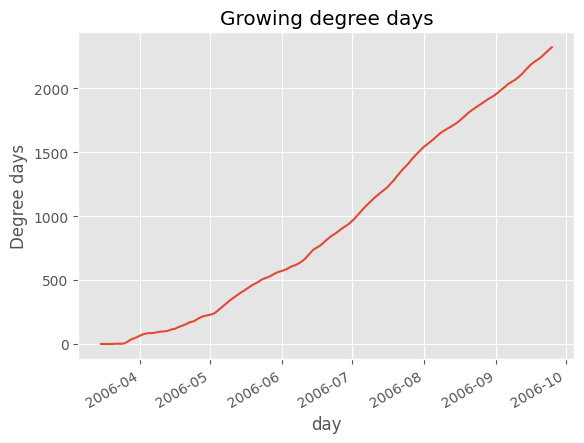

In [16]:
# 导入所需的绘图模块
# import matplotlib.pyplot as plt

# 使用df2中的GDD列进行绘图
ax = df2['GDD'].plot()

# 设置y轴标签和图表标题
ax.set_ylabel("Degree days")
ax.set_title("Growing degree days")

# 获取当前图像
fig = plt.gcf()

# 自动调整x轴日期格式，使其更易读
fig.autofmt_xdate()

# 4. 模型组件间的相互作用

一个单独的模型本身可能是有用的，但我们通常对系统不同组件之间的相互作用感兴趣。对于农作物来说，这通常涉及土壤和农作物之间的相互作用，但也可能是病虫害的发展情况，例如，病虫害的发展会受到农作物生长阶段的影响。

## 水分胁迫下物候发育加速
为了演示农作物和土壤之间的相互作用，我们将以一些农作物在水分胁迫下会加速其物候发育的情况为例。为了对此进行建模，我们需要两个新的组件：
1. 一个能描述农作物所经历的水分胁迫状况的模型。实际上就是一个模拟土壤中水分可利用性的模型。
2. 一份关于水分胁迫对物候发育速率影响的描述。

对于前者，我们将使用一个极其简单的土壤水分模型，该模型将土壤湿度建模为分段线性函数：在4月1日之前保持土壤湿润，然后逐渐使土壤变干，直至8月15日达到给定的土壤水分亏缺值。从那时起，我们假设土壤湿度再次线性增加，直至11月1日再次完全湿润。

对于后者，我们将使用一个线性函数，该函数将发育速率的相对增加描述为水分胁迫因子的函数。

### 土壤水分模型
土壤水分模型由以下几个参数来描述：
- 田间持水量，它定义了土壤湿润时的相对土壤湿度含量。
- 萎蔫点，它定义了植物无法再从土壤中吸收水分时的相对土壤含水量。
- 亏缺因子，它定义了我们让土壤变干的程度，以田间持水量和萎蔫点之间的分数（0 - 1）来表示。

此外，我们将假设当土壤含水量处于田间持水量和萎蔫点的中间值（临界水平）时，植物开始感受到水分胁迫，并且这种水分胁迫在该临界水平和萎蔫点之间呈线性增加。水分胁迫用“水分胁迫因子（WaterStressFactor）”来表示，当没有胁迫发生时，其值为0，当达到萎蔫点时，其值线性增加到1。

请注意，这个土壤水分模型并没有定义实际发生的任何动态过程（土壤水流、根系吸水、入渗、毛管上升等），但它确实达到了演示PCSE模型中模型组件间相互作用的目的。

下图展示了规定的土壤水分含量水平。

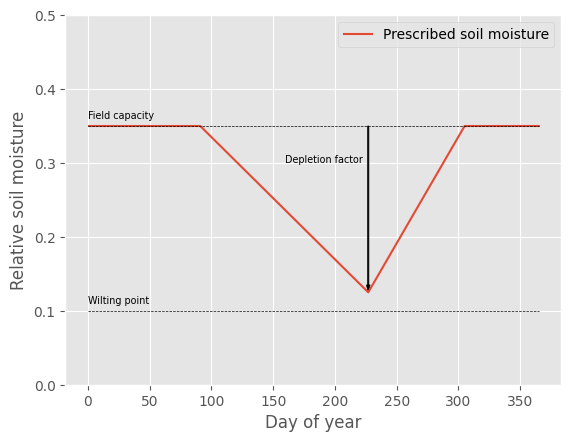

In [17]:
# 导入计算日序数的函数
from pcse.util import doy
# import datetime as dt
# import matplotlib.pyplot as plt

# 定义土壤湿度相关常量
FieldCapacity = 0.35  # 土壤田间持水量
WiltingPoint = 0.1   # 土壤凋萎点（水分最低限度）
DepletionFactor = 0.9  # 耗竭系数

# 计算耗尽后的土壤水分
SM_depleted = FieldCapacity - (FieldCapacity-WiltingPoint) * DepletionFactor

# 构建季节性土壤湿度列表
# 利用日序数表示时间，配合土壤湿度值
seasonal_soil_moisture = [
    # 第一天
    doy(dt.date(2006,1,1)), FieldCapacity,
    # 第二天
    doy(dt.date(2006,4,1)), FieldCapacity,
    # 第三天
    doy(dt.date(2006,8,15)), SM_depleted,
    # 第四天
    doy(dt.date(2006,11,1)), FieldCapacity,
    # 第五天
    doy(dt.date(2006,12,31)), FieldCapacity,
]

# 创建图表和坐标轴
fig, ax = plt.subplots()

# 绘制土壤湿度随时间变化的折线图
ax.plot(seasonal_soil_moisture[::2], seasonal_soil_moisture[1::2], label="Prescribed soil moisture")

# 设置y轴范围
ax.set_ylim(0, 0.5)

# 设置x轴标签
ax.set_xlabel("Day of year")

# 设置y轴标签
ax.set_ylabel("Relative soil moisture")

# 绘制田间持水量水平线
ax.plot([0,365], [FieldCapacity, FieldCapacity], linestyle="--", color="black", linewidth=0.5)

# 添加文字注解田间持水量
ax.text(0, 0.36, "Field capacity", fontsize="x-small")

# 绘制凋萎点水平线
ax.plot([0,365], [WiltingPoint, WiltingPoint], linestyle="--", color="black", linewidth=0.5)

# 添加文字注解凋萎点
ax.text(0, 0.11, "Wilting point", fontsize="x-small")

# 绘制箭头表示耗损程度
plt.arrow(
    doy(dt.date(2006,8,15)),  # 起始横坐标
    FieldCapacity,           # 起始纵坐标
    0,                       # 箭头宽度为0，即只在垂直方向上移动
    -1 * (FieldCapacity - SM_depleted),  # 垂直方向上的移动距离
    width=1,                 # 箭头宽度
    head_length=0.01,        # 箭头长度
    color="black",           # 颜色
    length_includes_head=True  # 包含箭头在内的总长度
)

# 添加文字注解耗损因子
ax.text(160, 0.30, "Depletion factor", fontsize="x-small")

# 显示图例
r = ax.legend()

### 考虑水分胁迫影响的积温（GDD）模型

经过修改的积温模型现在新增了一个参数“最大相对积温增长率（MaxRelativeGDDincrease）”，该参数用于指定在完全水分胁迫（土壤湿度处于萎蔫点）情况下积温速率的相对增长值。这个参数会与土壤水分模型提供的水分胁迫因子（WaterStressFactor）相乘，以模拟积温速率的增长情况。

以下是土壤水分模型以及考虑水分胁迫下物候加速的修改后积温模型的实现代码。这里有一个重要细节，即土壤水分模型中的水分胁迫因子是一个公开变量，这使得积温模型能够从[变量展示](https://pcse.readthedocs.io/en/stable/reference_guide.html#the-variablekiosk)获取到它。

In [18]:
%%writefile gddmodel_v3.py

# 导入必要的模块和类
import datetime as dt
from pcse.base import SimulationObject, StatesTemplate, RatesTemplate, ParamTemplate
from pcse.util import doy, limit, AfgenTrait
from pcse.traitlets import Float, Instance
from pcse import signals

class GrowingDegreeDayModelV3(SimulationObject):
    """
    一个简单的模型用于累计生长度日直到达到成熟所需的度日数（GDD）。该模型
    存储成熟日期，并在达到成熟时触发作物结束信号。

    生长速率（rGDD）通过一个因子调整，该因子在水分胁迫下增加rGDD。
    """

    # 参数模板
    class Parameters(ParamTemplate):
        BaseTemperature = Float  # 基础温度
        GDDatMaturity = Float   # 成熟所需度日数
        MaxRelativeGDDincrease = Float  # 最大的相对GDD增长率

    # 状态变量模板
    class StateVariables(StatesTemplate):
        GDD = Float             # 当前累积度日
        DayofMaturity = Instance(dt.date)  # 成熟日期

    # 速率变量模板
    class RateVariables(RatesTemplate):
        rGDD = Float            # 当前生长度日速率

    # 初始化方法
    def initialize(self, day, kiosk, parameters):
        # 保存参数
        self.params = self.Parameters(parameters)
        # 初始化状态变量
        self.states = self.StateVariables(kiosk, GDD=0.0, DayofMaturity=None)
        # 初始化速率变量
        self.rates = self.RateVariables(kiosk)

    # 计算速率方法
    def calc_rates(self, day, drv):
        # 计算增强的GDD增长速率
        # 注意：WaterStressFactor由土壤模块提供，可以通过self.kiosk访问
        relGDDinc = 1.0 + self.params.MaxRelativeGDDincrease * self.kiosk.WaterStressFactor
        self.rates.rGDD = max(0, drv.TEMP - self.params.BaseTemperature) * relGDDinc

    # 积分更新方法
    def integrate(self, day, delt):
        self.states.GDD += self.rates.rGDD * delt
        if self.states.GDD >= self.params.GDDatMaturity:
            self.states.DayofMaturity = day
            # 当成熟时发送信号
            self._send_signal(day=day, signal=signals.crop_finish, crop_delete=True)


# 基本土壤水分模型
class BasicSoilWaterModel(SimulationObject):

    # 参数模板
    class Parameters(ParamTemplate):
        FieldCapacity = Float          # 田间持水量
        WiltingPoint = Float           # 凋萎点
        SeasonalSoilMoisture = AfgenTrait  # Afgen是一个线性插值对象

    # 状态变量模板
    class StateVariables(StatesTemplate):
        SoilMoisture = Float           # 土壤湿度
        WaterStressFactor = Float      # 水分胁迫因子

    # 初始化方法
    def initialize(self, day, kiosk, parameters):
        self.params = self.Parameters(parameters)
        # 计算临界水平，即田间持水量与凋萎点之间的中点
        self._critical_level = (self.params.FieldCapacity + self.params.WiltingPoint)/2.0
    
        # 根据日期获取土壤湿度
        SM = self.params.SeasonalSoilMoisture(doy(day))
        self.states = self.StateVariables(kiosk, SoilMoisture=SM, WaterStressFactor=0.0, publish=["WaterStressFactor"])

    # 计算速率方法
    def calc_rates(self, day, drv):
        # 此模型没有动力学，因此无需计算变化率
        pass

    # 积分更新方法
    def integrate(self, day, delt):
        # 通过基于日历年插值获取土壤湿度，Afgen负责线性插值
        self.states.SoilMoisture = self.params.SeasonalSoilMoisture(doy(day))
        # 计算水分胁迫因子，并限制在0到1之间
        WSF = (self._critical_level - self.states.SoilMoisture)/(self._critical_level - self.params.WiltingPoint)
        self.states.WaterStressFactor = limit(0.0, 1.0, WSF)

Overwriting gddmodel_v3.py


### 作物和土壤组件的配置
新的配置文件会同时导入积温（GDD）模型和土壤水分模型，并将它们分别赋给作物（CROP）和土壤（SOIL）变量。此外，在输出变量（OUTPUT_VARS）列表中还新增了两项输出内容。

### 模型输入
新模型需要额外的输入参数。因此，我们不仅要传递作物参数，还需要传递土壤模型的参数。

请注意，我还更新了农业管理的定义：我添加了一个[“后续为空的活动”](https://pcse.readthedocs.io/en/stable/reference_guide.html#finding-the-start-and-end-date-of-a-simulation)，以强制系统运行到2006年12月31日。这确保了我们能够绘制全年的数据，并查看全年的土壤水分可利用性和水分胁迫因子。

In [19]:
# 初始化作物参数字典，包含作物的基础温度、成熟时所需的有效积温以及最大相对有效积温增长率
cropd = dict(
    BaseTemperature=3.0,         # 基础温度 (摄氏度)
    GDDatMaturity=1500.,         # 成熟时所需的有效积温 (度日)
    MaxRelativeGDDincrease=0.5   # 最大相对有效积温增长率
)

# 初始化土壤参数字典，包括田间持水量、萎蔫点及季节性土壤湿度
soild = dict(
    FieldCapacity=FieldCapacity,     # 田间持水量 (m³/m³)
    WiltingPoint=WiltingPoint,       # 萎蔫点 (m³/m³)
    SeasonalSoilMoisture=seasonal_soil_moisture    # 季节性土壤湿度 (m³/m³)
)

# 创建参数提供器对象，传入作物数据、站点数据（此处为空）和土壤数据
params = ParameterProvider(cropdata=cropd, sitedata={}, soildata=soild)

# 使用yaml安全加载器加载农业管理配置，从文本字符串中读取数据
# 这段配置包含了两个日期键点，第一个日期定义了作物日历的设置，
# 包括作物名称、品种名称、开始日期、结束类型和最大持续时间。
# 第二个日期暂未指定具体配置
agro = yaml.safe_load("""
- 2006-01-01:
    CropCalendar:
        crop_name: 'GDDCrop'          # 作物名称
        variety_name: 'GDDVariety'    # 品种名称
        crop_start_date: 2006-03-15   # 作物开始日期
        crop_start_type: emergence    # 作物开始类型
        crop_end_date: null           # 作物结束日期（默认null表示自动判断）
        crop_end_type: maturity       # 作物结束类型
        max_duration: 300             # 最大持续天数
    TimedEvents: null                 # 时间事件（无）
    StateEvents: null                 # 状态事件（无）
- 2006-12-31:                         # 此日期的配置未指定，可能是预留用于后续扩展
""")

现在让我们运行这个包含土壤和积温（GDD）模型相互作用的模型。

In [20]:
# 定义GDD模型配置文件路径，当前工作目录下的"gddmodel_v3.conf"文件
gdd_config = Path.cwd() / "gddmodel_v3.conf"

# 使用ParameterProvider实例、WeatherDataProvider实例、AgroManagement实例以及配置文件路径创建Engine对象
# 注意：这里假设wdp为已初始化的WeatherDataProvider实例，它提供了气象数据
gddmodelv3 = Engine(params, wdp, agro, config=gdd_config)

# 运行GDD模型直到终止条件满足，这将执行整个作物生长周期的模拟
gddmodelv3.run_till_terminate()

# 将模型输出结果转换为Pandas DataFrame，设置索引为"day"，便于时间序列分析
df3 = pd.DataFrame(gddmodelv3.get_output()).set_index("day")

# 打印模型的汇总输出信息，通常包含关键指标和统计数据
print(gddmodelv3.get_summary_output())

[{'GDD': 1523.618529411765, 'DayofMaturity': datetime.date(2006, 7, 26)}]


正如你从上述结果的汇总输出中可以看到的那样，该模型现在于2006年7月26日达到成熟，比未考虑水分胁迫影响的模型提前了4天。从下面展示积温累积差异、土壤湿度水平以及水分胁迫因子的图表中，这一点也很明显。

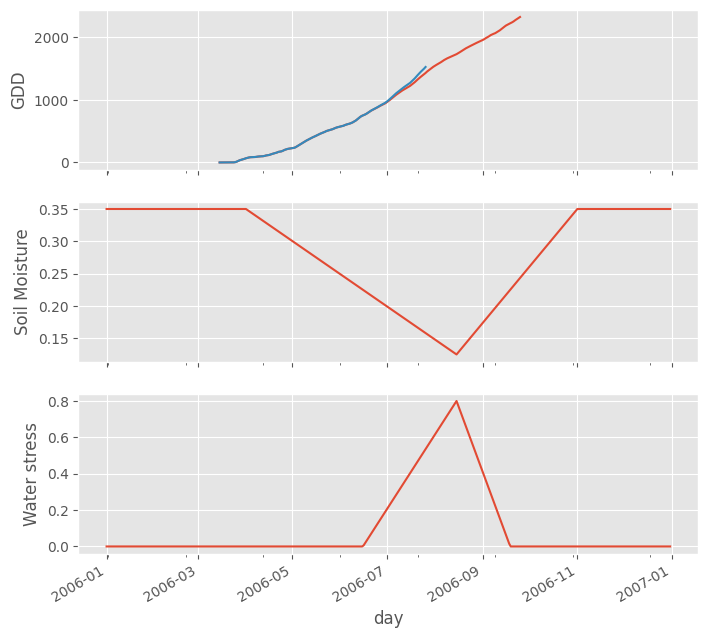

In [21]:
# 创建一个包含三个子图的图形，每个子图共享相同的 x 轴
fig, axes = plt.subplots(nrows=3, figsize=(8,8), sharex=True)

# 绘制无水分胁迫条件下的 GDD
df2.GDD.plot(ax=axes[0], label="No water stress")

# 绘制有水分胁迫条件下的 GDD
df3.GDD.plot(ax=axes[0], label="With water stress")

# 绘制土壤水分
df3.SoilMoisture.plot(ax=axes[1])

# 绘制水分胁迫因子
df3.WaterStressFactor.plot(ax=axes[2])

# 设置第一个子图的 y 轴标签为 "GDD"
axes[0].set_ylabel("GDD")

# 设置第二个子图的 y 轴标签为 "Soil Moisture"
axes[1].set_ylabel("Soil Moisture")

# 设置第三个子图的 y 轴标签为 "Water stress"
axes[2].set_ylabel("Water stress")

# 自动格式化 x 轴的日期标签，使其更易读
fig.autofmt_xdate()

# 5. Concluding remarks
# 5. 结束语